In [1]:
!pip install accelerate==0.34.2
!pip install spacy
!python -m spacy download en

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 8.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.0/468.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: safetensors
    Found existing installation: safetensors 0.4.1
    Uninstalling safetensors-0.4.1:
      Successfully uninstalled safetensors-0.4.1
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.2
    Uninstalling huggingface-hub-0.20.2:
      Successfully uninstalled huggingface-hub-0.20.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.2/29.2 MB 10.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.8/204.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.0/183.0 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.9/156.

In [2]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import re


with open('dataset.json', 'r', encoding="utf-8") as file:
  data = json.load(file)

def shorten_article(entry):
    #entry["article"] = entry["article"][:int(len(entry["article"])*0.3)]
    cleaned_text = re.sub(r'\b(Donald|donald|Trump|trump|former|Former|president|President|Joe|joe|Biden|biden)\b', '', entry["article"])
    entry["article"] = cleaned_text.strip()
    return entry

#data = [shorten_article(entry) for entry in data]

df = pd.DataFrame(data)
#print(df)
#df = df.sample(frac=0.3,random_state=42)

label_mapping = {"left": 0, "lean-left": 1, "lean-right": 2, "right": 3}
df["label"] = df['label'].map(label_mapping)

train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['article'], df['label'], test_size=0.3, stratify=df['label'], random_state=30)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify = temp_labels, random_state=30)

/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.10/site-packages/accelerate/accelerator.py:457: FutureWarning: Passing the following arguments to `Acce

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.315677,0.897842,0.897433,0.899881,0.897842
2,0.426700,0.228518,0.927578,0.927638,0.929689,0.927578
3,0.426700,0.260872,0.935252,0.935185,0.936031,0.935252


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Evaluation Results: {'eval_loss': 0.2608719766139984, 'eval_accuracy': 0.935251798561151, 'eval_f1': 0.9351852381834836, 'eval_precision': 0.9360312227150805, 'eval_recall': 0.935251798561151, 'eval_runtime': 20.3723, 'eval_samples_per_second': 102.345, 'eval_steps_per_second': 3.24, 'epoch': 3.0}
Testing the model...
Test Results: {'eval_loss': 0.2170383632183075, 'eval_accuracy': 0.9400767018216682, 'eval_f1': 0.9400273005909096, 'eval_precision': 0.941272255634945, 'eval_recall': 0.9400767018216682, 'eval_runtime': 20.1683, 'eval_samples_per_second': 103.43, 'eval_steps_per_second': 3.272, 'epoch': 3.0}
Generating confusion matrix...


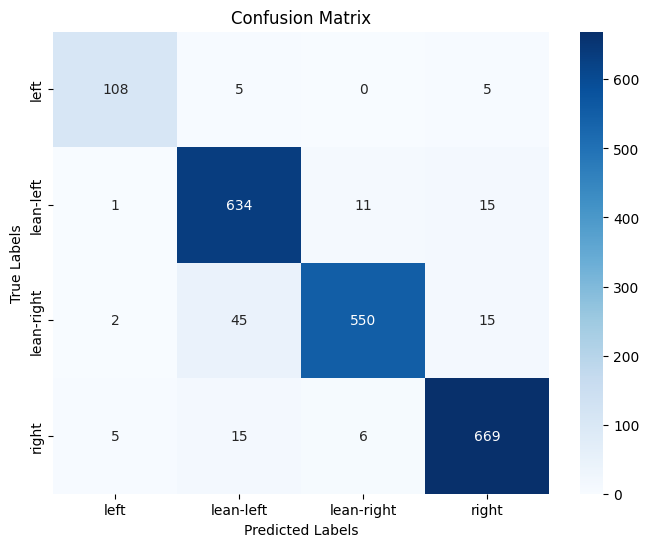

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification

device = torch.device("cuda")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, 128)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, 128)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, 128)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)



model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
model.to(device)


training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    report_to=[]
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

print("Testing the model...")
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Generate confusion matrix
print("Generating confusion matrix...")
raw_preds = trainer.predict(test_dataset)
preds = raw_preds.predictions.argmax(-1)
conf_matrix = confusion_matrix(test_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [6]:
import spacy
from tqdm import tqdm

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Load trained model and tokenizer
model.eval()

# Function to classify sentences
def classify_sentences(text, model, tokenizer):
    sentences = [sent.text for sent in nlp(text).sents]
    inputs = tokenizer(sentences, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    labels = probs.argmax(dim=-1).tolist()
    scores = probs.max(dim=-1).values.tolist()
    return list(zip(sentences, labels, scores))

# Process all articles
all_sentence_results = []
for article in tqdm(df["article"], desc="Processing Articles", unit="article"):
    try:
        all_sentence_results.extend(classify_sentences(article, model, tokenizer))
    except:
        continue

# Convert to DataFrame for easy analysis
sentence_df = pd.DataFrame(all_sentence_results, columns=["Sentence", "Predicted Label", "Score"])

# Ensure full sentences are displayed
pd.set_option("display.max_colwidth", None)

# Show top-scoring sentences across the dataset
print(sentence_df.sort_values(by="Score", ascending=False).head(40))  # Adjust number as needed


Processing Articles: 100%|██████████| 13903/13903 [21:39<00:00, 10.70article/s]


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Sentence  \
211959                                                                                                                                                                                       

/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/opt/miniconda3/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/miniconda3/lib/python3.10/site-packages/accelerate/acceler

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.203943,0.932652,0.932478,0.934918,0.932652
2,0.409800,0.168371,0.950766,0.950736,0.951097,0.950766
3,0.409800,0.168957,0.958198,0.958132,0.958387,0.958198


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.


Evaluation Results: {'eval_loss': 0.1689574122428894, 'eval_accuracy': 0.9581978634463539, 'eval_f1': 0.9581315293400979, 'eval_precision': 0.9583874152032368, 'eval_recall': 0.9581978634463539, 'eval_runtime': 8.8657, 'eval_samples_per_second': 242.845, 'eval_steps_per_second': 7.67, 'epoch': 3.0}
Testing the model...
Test Results: {'eval_loss': 0.21759194135665894, 'eval_accuracy': 0.9512534818941504, 'eval_f1': 0.9511890267992479, 'eval_precision': 0.951524089540612, 'eval_recall': 0.9512534818941504, 'eval_runtime': 8.9392, 'eval_samples_per_second': 240.961, 'eval_steps_per_second': 7.607, 'epoch': 3.0}
Generating confusion matrix...


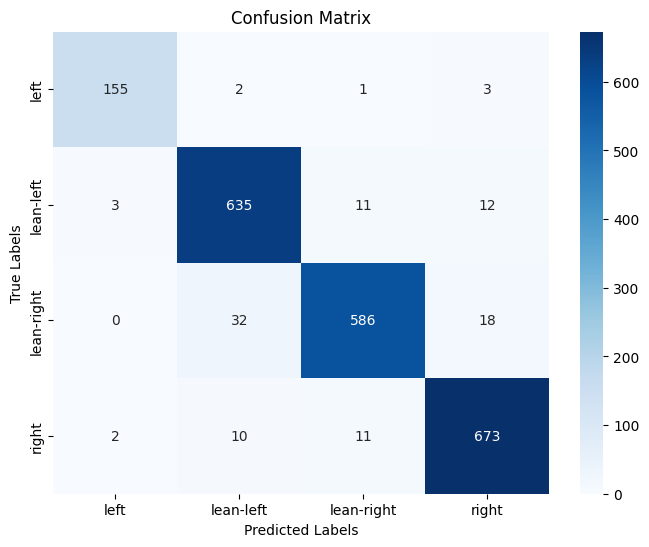

In [21]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(texts):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, 128)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, 128)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer, 128)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)
test_dataloader = DataLoader(test_dataset, batch_size=16)


model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=4)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=1e-4,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    report_to=[]
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

model.save_pretrained('./saved_model')
tokenizer.save_pretrained('./saved_model')

print("Testing the model...")
test_results = trainer.evaluate(test_dataset)
print("Test Results:", test_results)

# Generate confusion matrix
print("Generating confusion matrix...")
raw_preds = trainer.predict(test_dataset)
preds = raw_preds.predictions.argmax(-1)
conf_matrix = confusion_matrix(test_labels, preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()